### Preparation

In [375]:
# Configure root ..
import os
import sys
os.chdir("..")  

In [401]:
# Libraries & Packages
from src import config
import gspread
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None) 

## Import & Adjustments

In [377]:
# Import Excel files ~> TO log & Daily log
googleDrive_client = gspread.authorize(config.DRIVE_CREDENTIALS)
config.DRIVE_TP_LOG_FILENAMES

# Daily Log
daily_log_file = googleDrive_client.open(config.DRIVE_DAILY_LOG_FILENAMES[0])
daily_log_sheet = daily_log_file.get_worksheet(0)
daily_log_data = daily_log_sheet.get_all_values()
daily_log_df = pd.DataFrame(daily_log_data[1:], columns=daily_log_data[0]) 

# TP Log
tp_log_file = googleDrive_client.open(config.DRIVE_TP_LOG_FILENAMES[0])
tp_log_sheet = tp_log_file.get_worksheet(0)
tp_log_data = tp_log_sheet.get_all_values()
tp_log_df = pd.DataFrame(tp_log_data[1:], columns=tp_log_data[0]) 

In [378]:
# Small adjustments

# Convert to numeric (all are object ...)
def safe_convert(x):
    if x == "":
        return np.nan  # Treat empty strings as NaN
    try:
        return pd.to_numeric(x)
    except (ValueError, TypeError):
        return str(x)
    
for data in [daily_log_df, tp_log_df]:
    for col in data.columns:
        try:
            data[col] = data[col].apply(safe_convert)
        except ValueError:
            pass 

# Date & Datetime
daily_log_df["Date"] = pd.to_datetime(daily_log_df[["Year", "Month", "Day"]]).dt.date
tp_log_df["Date"] = pd.to_datetime(tp_log_df[["Year", "Month", "Day"]]).dt.date
daily_log_df["Datetime"] = pd.to_datetime(daily_log_df[["Year", "Month", "Day"]])
tp_log_df["Datetime"] = pd.to_datetime(tp_log_df[["Year", "Month", "Day"]])

# Sort by date
daily_log_df = daily_log_df.sort_values(by="Date").reset_index(drop=True)
tp_log_df = tp_log_df.sort_values(by="Date").reset_index(drop=True)

# Some conversions
tp_log_df["Activity type"] = tp_log_df["Activity type"].replace({"Cycling": "Road Biking"}) #  Convert Cycling to Road Biking in Activity type
tp_log_df["Activity type"] = tp_log_df["Activity type"].str.replace("Cycling", "Biking") # cycling to biking in Activity type

In [379]:
# Data check

print("Daily Log:")
print("-------------------------------------")
print("Date range: {} to {}".format(daily_log_df["Date"].min(), daily_log_df["Date"].max()))
print("Duplicated rows = {}".format(daily_log_df[daily_log_df.duplicated(keep=False)].shape[0]))
print("Missing dates = {}".format([d for d in pd.date_range(start=daily_log_df["Date"].min(), end=daily_log_df["Date"].max()).date if d not in daily_log_df["Date"].values]))


print("\nTraining Log:")
print("-------------------------------------")
print("Date range: {} to {}".format(tp_log_df["Date"].min(), tp_log_df["Date"].max()))
print("Duplicated rows = {}".format(tp_log_df[tp_log_df.duplicated(keep=False)].shape[0]))
print("Missing dates = {}".format([d for d in pd.date_range(start=tp_log_df["Date"].min(), end=tp_log_df["Date"].max()).date if d not in tp_log_df["Date"].values]))

Daily Log:
-------------------------------------
Date range: 2024-09-13 to 2025-08-14
Duplicated rows = 0
Missing dates = []

Training Log:
-------------------------------------
Date range: 2024-09-13 to 2025-08-14
Duplicated rows = 0
Missing dates = []


## Work on data

In [380]:
# Work!

# Normalized HRV values (-inf, inf) ~> Upper bound = 1, Lower bound = 0 ~> Lower = better
daily_log_df["HRV normalized"] = (daily_log_df["HRV"] - daily_log_df["HRV baseline lower"]) / (daily_log_df["HRV baseline upper"] - daily_log_df["HRV baseline lower"])

# Performance vs. effor ~> Heart rate vs. Gradient adjusted pace
# --> "Running efficiency index (EF)" = Gradient adjusted pace / Average heart rate
def EF_formula(avg_pace, avg_hr):
    if avg_hr == 0:
        return np.nan 
    return avg_pace / avg_hr

## Quick Analysis

#### Training log

In [381]:
# Quick analyis ~ Training log

print("Different activities and their counts:")
print("-------------------------------------")
activities_count_time = (
    tp_log_df
    .groupby("Activity type")[["Duration [h]"]]
    .agg(
        count=("Duration [h]", "count"),
        total_duration=("Duration [h]", "sum")
        )
    .reset_index()
    .sort_values(by="total_duration", ascending=False)
    )

for _, row in activities_count_time.iterrows():
    print("{} ~> {:.2f} hours, ({} act.)".format(row["Activity type"], row["total_duration"], row["count"]))

Different activities and their counts:
-------------------------------------
Trail Running ~> 268.09 hours, (144 act.)
Road Biking ~> 84.39 hours, (35 act.)
Running ~> 78.25 hours, (76 act.)
Indoor Biking ~> 71.04 hours, (51 act.)
Hiking ~> 15.35 hours, (6 act.)
Mountain Biking ~> 12.67 hours, (7 act.)
Lap Swimming ~> 0.21 hours, (1 act.)


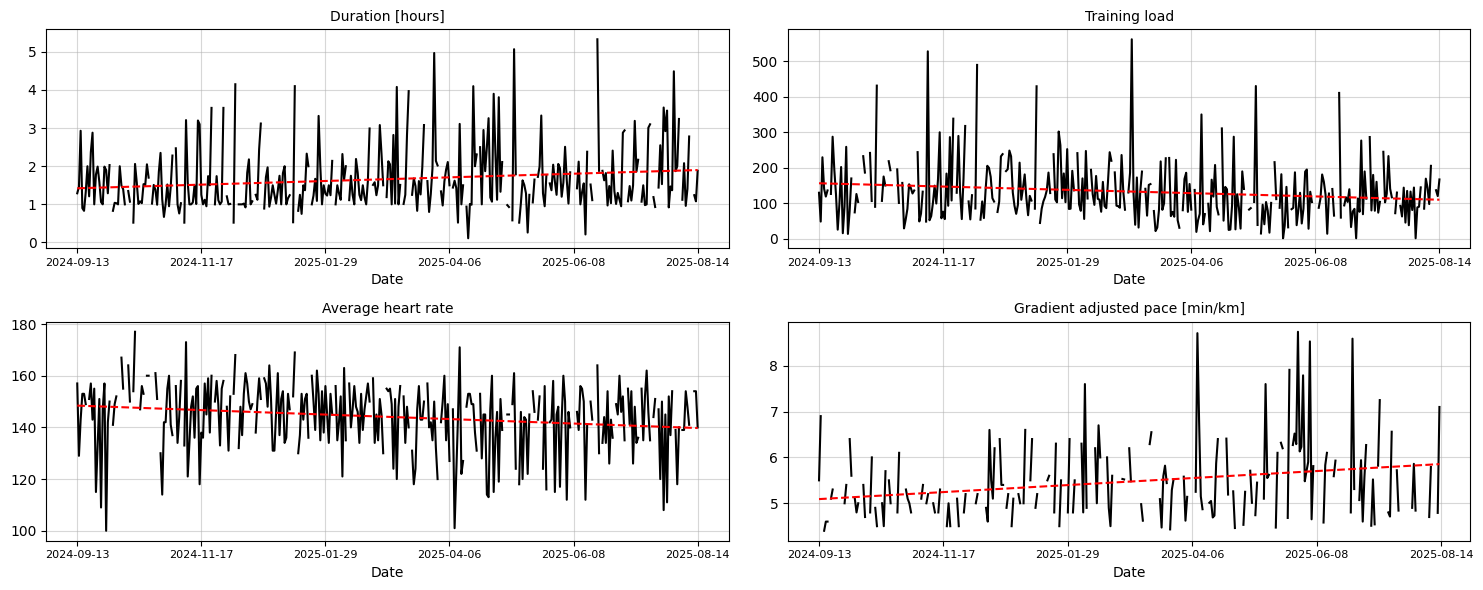

In [382]:
# Some Training log trends

fig, ax = plt.subplots(2, 2, figsize=(15, 6))
indices = np.arange(0, len(tp_log_df["Datetime"]))

ax[0,0].set_title("Duration [hours]", fontsize=10)
ax[0,0].plot(indices, tp_log_df["Duration [h]"], label="VO2max", color="black")
sns.regplot(x=indices, y=tp_log_df["Duration [h]"], color="red", line_kws={"linestyle":"--", "linewidth":1.5}, ci=None, scatter=False, ax=ax[0,0])

ax[0,1].set_title("Training load", fontsize=10)
ax[0,1].plot(indices, tp_log_df["Training load"], label="VO2max", color="black")
sns.regplot(x=indices, y=tp_log_df["Training load"], color="red", line_kws={"linestyle":"--", "linewidth":1.5}, ci=None, scatter=False, ax=ax[0,1])

ax[1,0].set_title("Average heart rate", fontsize=10)
ax[1,0].plot(indices, tp_log_df["Average heart rate"], label="VO2max", color="black")
sns.regplot(x=indices, y=tp_log_df["Average heart rate"], color="red", line_kws={"linestyle":"--", "linewidth":1.5}, ci=None, scatter=False, ax=ax[1,0])

ax[1,1].set_title("Gradient adjusted pace [min/km]", fontsize=10)
ax[1,1].plot(indices, tp_log_df["Gradient adjusted pace [min/km]"], label="VO2max", color="black")
sns.regplot(x=indices, y=tp_log_df["Gradient adjusted pace [min/km]"], color="red", line_kws={"linestyle":"--", "linewidth":1.5}, ci=None, scatter=False, ax=ax[1,1])

for i in [0,1]:
    for j in [0,1]:
        ax[i,j].set_xticks(indices[::max(1, len(indices)//5)])  
        ax[i,j].set_xticklabels(tp_log_df["Datetime"].dt.strftime("%Y-%m-%d")[::max(1, len(indices)//5)], fontsize=8, rotation=0)
        ax[i,j].set_xlabel("Date")
        ax[i,j].set_ylabel("")
        ax[i,j].grid(alpha=.5)

plt.tight_layout()
plt.show()

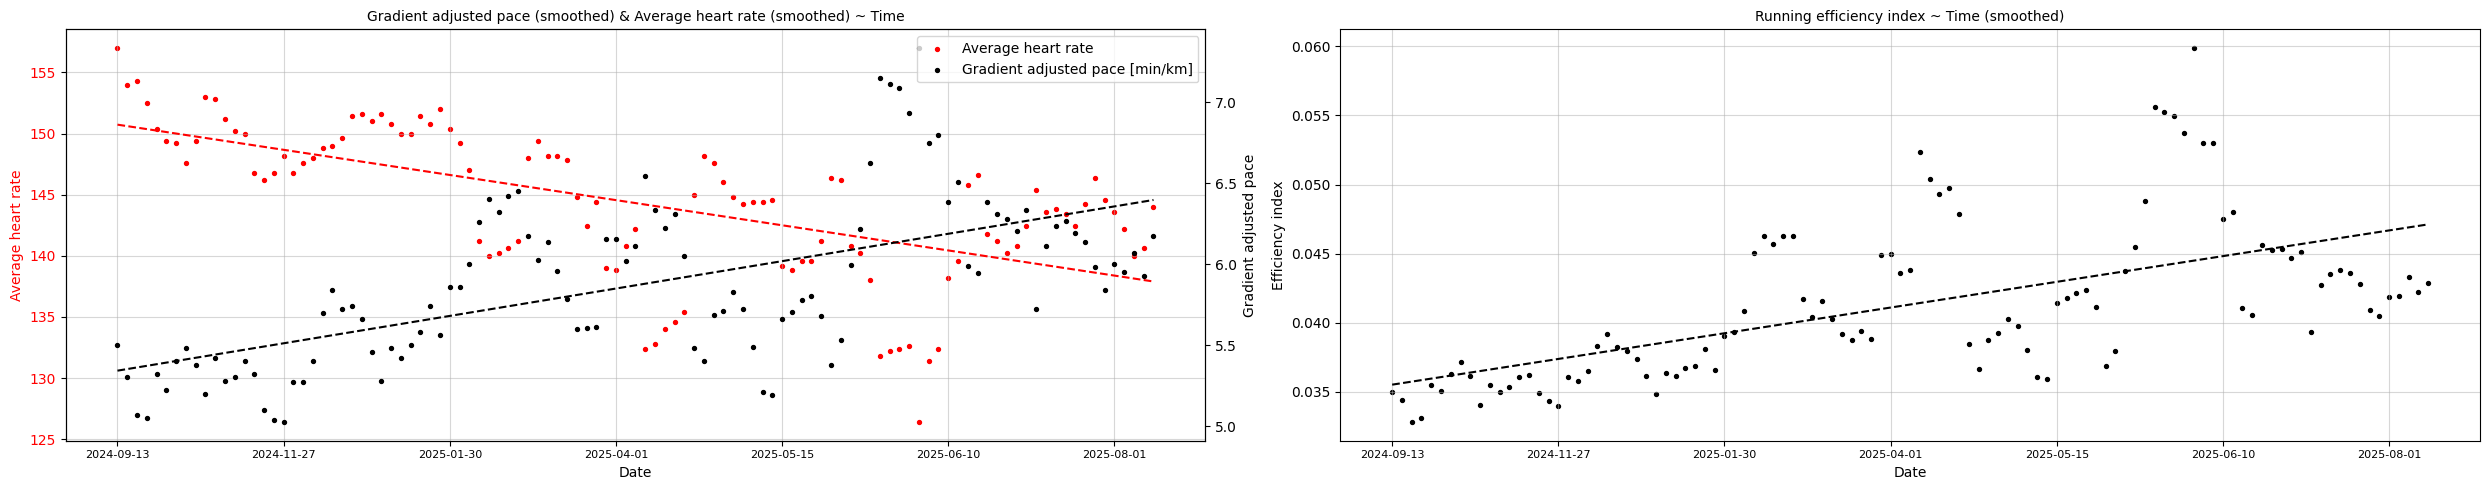

In [427]:
# Aerobic runs ~ Relationship between Gradient adjusted pace & Average heart rate 

# Prepare
aerobic_runs = (
    tp_log_df
    .query("`Activity type` in (['Trail Running', 'Running'])") # Trail running
    .query("`Description`.str.contains('Running')") # Normal runs ~ No specific training (aerobic runs)
    .query("`Aerobic training effect` < 5.0") # Filter out races
    )

aerobic_runs["Gradient adjusted pace [min/km] smoothed"] = aerobic_runs["Gradient adjusted pace [min/km]"].rolling(window=5, min_periods=1).mean()
aerobic_runs["Average heart rate smoothed"] = aerobic_runs["Average heart rate"].rolling(window=5, min_periods=1).mean()

# Plot
fig, ax = plt.subplots(1,2, figsize=(25, 5))
indices = np.arange(0, len(aerobic_runs["Datetime"]))

# Plot 1
ax[0].set_title("Gradient adjusted pace (smoothed) & Average heart rate (smoothed) ~ Time", fontsize=10)
ax[0].scatter(indices, aerobic_runs["Average heart rate smoothed"], label="Average heart rate", color="red", s=8)
sns.regplot(x=indices, y=aerobic_runs["Average heart rate smoothed"], color="red", line_kws={"linestyle":"--", "linewidth":1.5}, ci=None, scatter=False, ax=ax[0])
ax[0].set_ylabel("Average heart rate", color="red")
ax[0].tick_params(axis="y", labelcolor="red")

ax1 = ax[0].twinx()
ax1.scatter(indices, aerobic_runs["Gradient adjusted pace [min/km] smoothed"], label="Gradient adjusted pace [min/km]", color="black", s=8)
sns.regplot(x=indices, y=aerobic_runs["Gradient adjusted pace [min/km] smoothed"], color="black", line_kws={"linestyle":"--", "linewidth":1.5}, ci=None, scatter=False, ax=ax1)
ax1.set_ylabel("Gradient adjusted pace", color="black")
ax1.tick_params(axis="y", labelcolor="black")

handles1, labels1 = ax[0].get_legend_handles_labels()
handles2, labels2 = ax1.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc="upper right")

# Plot 2 ~> Running efficiency index
aerobic_runs["EF"] = aerobic_runs.apply(lambda row: EF_formula(row["Gradient adjusted pace [min/km]"], row["Average heart rate"]), axis=1)
aerobic_runs["EF smoothed"] = aerobic_runs["EF"].rolling(window=5, min_periods=1).mean()

ax[1].set_title("Running efficiency index ~ Time (smoothed)", fontsize=10)
ax[1].scatter(indices, aerobic_runs["EF smoothed"], color="black", s=8)
sns.regplot(x=indices, y=aerobic_runs["EF smoothed"], color="black", line_kws={"linestyle":"--", "linewidth":1.5}, ci=None, scatter=False, ax=ax[1])
ax[1].set_ylabel("Efficiency index", color="black")

for i in [0,1]:
    ax[i].set_xticks(indices[::max(1, len(indices)//6)])  
    ax[i].set_xticklabels(aerobic_runs["Datetime"].dt.strftime("%Y-%m-%d")[::max(1, len(indices)//6)], fontsize=8, rotation=0)
    ax[i].set_xlabel("Date")
    ax[i].grid(alpha=.5)

plt.tight_layout()
plt.show()

#### Daily log

In [384]:
# Quick analyis ~ Daily log
print("Current performance values:")
print("-------------------------------------")
print("VO2max ~> {:.2f} ml/kg/min".format(daily_log_df["vo2Max"].iloc[-1]))
print("Hill score ~> {}".format(daily_log_df["Hill score"].iloc[-1]))
print("Endurance score ~> {}".format(daily_log_df["Endurance score"].iloc[-1]))
print("Normalized HRV ~> {:.2f}".format(daily_log_df["HRV normalized"].iloc[-1]))

Current performance values:
-------------------------------------
VO2max ~> 60.70 ml/kg/min
Hill score ~> 93
Endurance score ~> 8631
Normalized HRV ~> 0.19


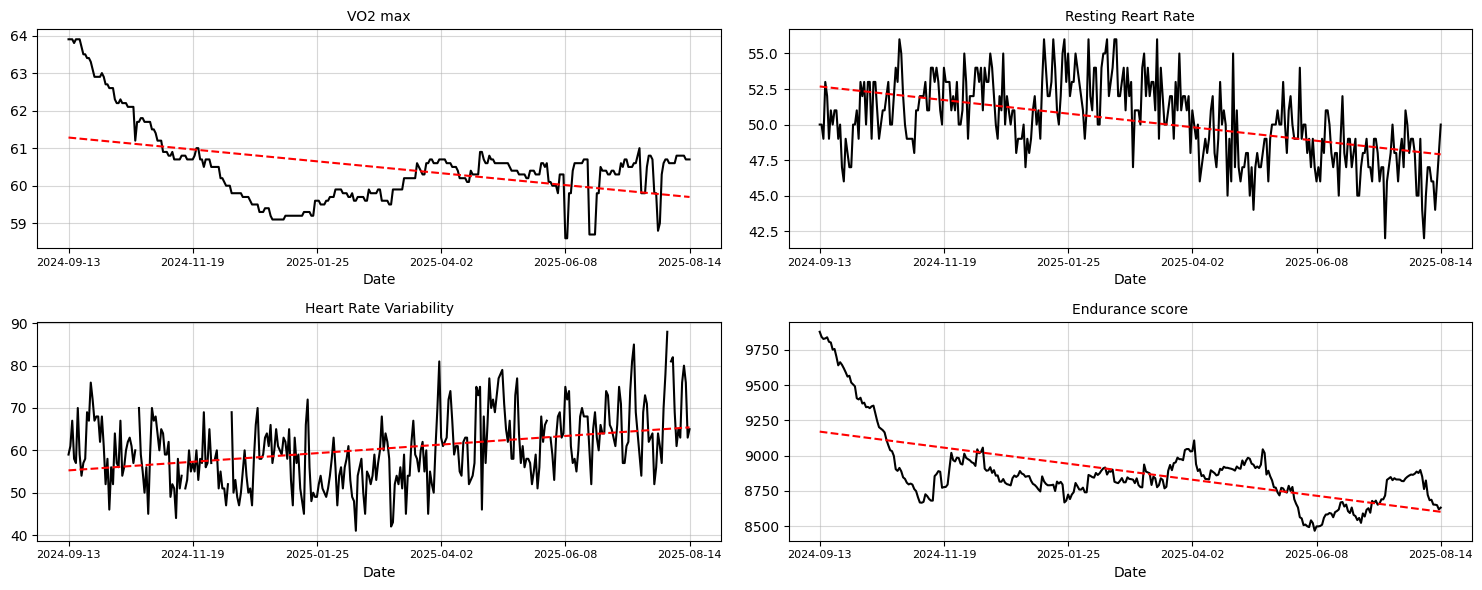

In [438]:
# Some Daily log trends
fig, ax = plt.subplots(2, 2, figsize=(15, 6))
indices = np.arange(0, len(daily_log_df["Datetime"]))

ax[0,0].set_title("VO2 max", fontsize=10)
ax[0,0].plot(indices, daily_log_df["vo2Max"], label="VO2max", color="black")
sns.regplot(x=indices, y=daily_log_df["vo2Max"], color="red", line_kws={"linestyle":"--", "linewidth":1.5}, ci=None, scatter=False, ax=ax[0,0])

ax[0,1].set_title("Resting Reart Rate", fontsize=10)
ax[0,1].plot(indices, daily_log_df["Resting HR"], label="VO2max", color="black")
sns.regplot(x=indices, y=daily_log_df["Resting HR"], color="red", line_kws={"linestyle":"--", "linewidth":1.5}, ci=None, scatter=False, ax=ax[0,1])

ax[1,0].set_title("Heart Rate Variability", fontsize=10)
ax[1,0].plot(indices, daily_log_df["HRV"], label="VO2max", color="black")
sns.regplot(x=indices, y=daily_log_df["HRV"], color="red", line_kws={"linestyle":"--", "linewidth":1.5}, ci=None, scatter=False, ax=ax[1,0])

ax[1,1].set_title("Endurance score", fontsize=10)
ax[1,1].plot(indices, daily_log_df["Endurance score"], label="VO2max", color="black")
sns.regplot(x=indices, y=daily_log_df["Endurance score"], color="red", line_kws={"linestyle":"--", "linewidth":1.5}, ci=None, scatter=False, ax=ax[1,1])

for i in [0,1]:
    for j in [0,1]:
        ax[i,j].set_xticks(indices[::max(1, len(indices)//5)])  
        ax[i,j].set_xticklabels(daily_log_df["Datetime"].dt.strftime("%Y-%m-%d")[::max(1, len(indices)//5)], fontsize=8, rotation=0)
        ax[i,j].set_xlabel("Date")
        ax[i,j].set_ylabel("")
        ax[i,j].grid(alpha=.5)

plt.tight_layout()
plt.show()

#### Training log & Daily log

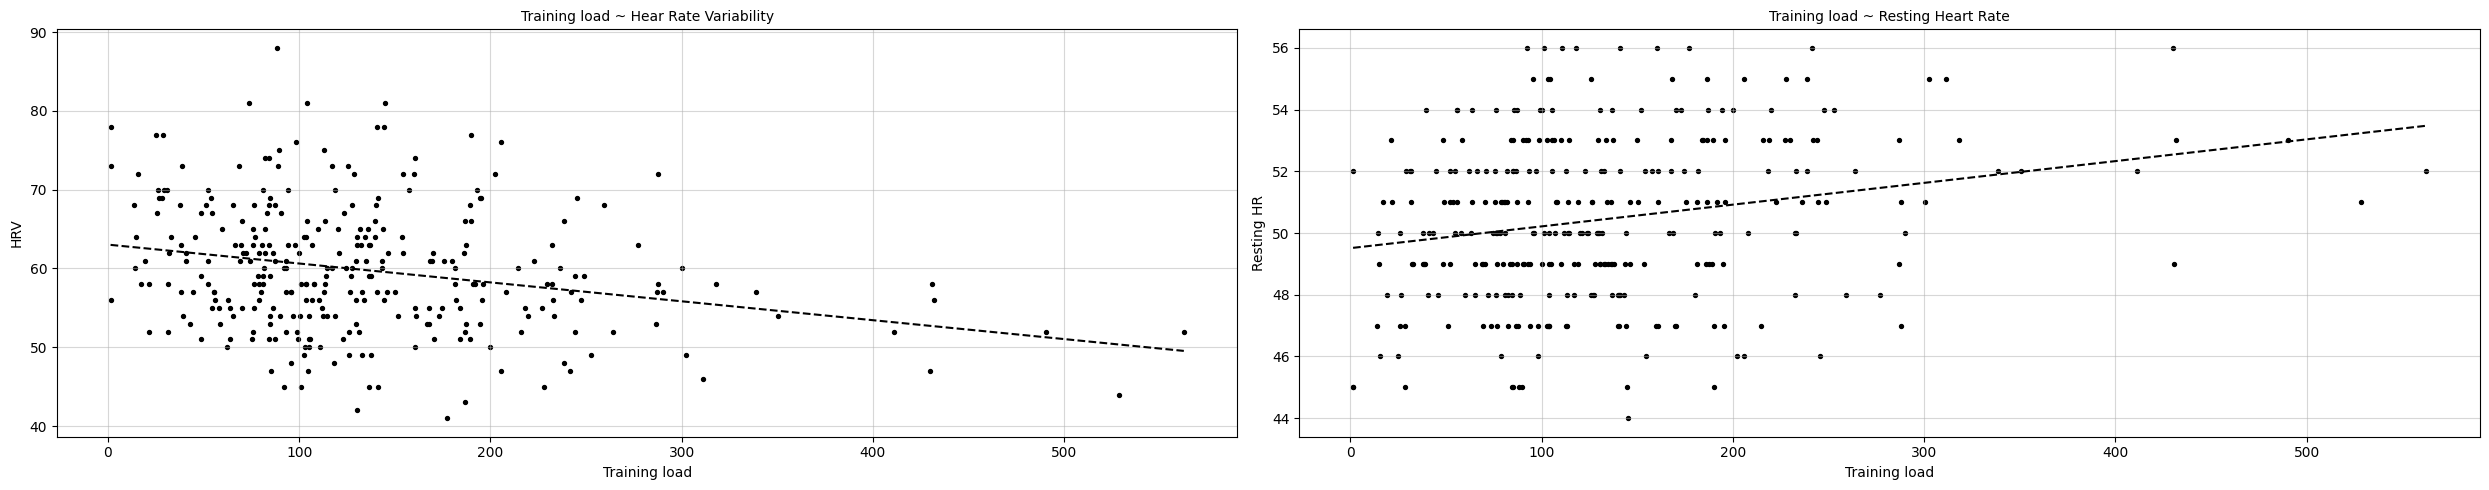

In [454]:
# Effect on hard training days on next days HRV and Resting HR


# Prepare
next_day_effect = (
    tp_log_df
    # Hard trainingy days ~> Aerobic >= 3.5 or Anaerobic
    .assign(hard_training_day = lambda df: (df["Aerobic training effect"] >= 3.5) | (df["Training effect label"].isin(['Tempo', 'Vo2max', 'Lactate threshold', 'Anaerobic capacity'])))
    [["Date", "Aerobic training effect", "Anaerobic training effect", "Training effect label", "Training load", "hard_training_day"]]
    .merge(
        daily_log_df[["Date", "HRV", "Resting HR"]]
        .assign(MergeDate = lambda df: df["Date"] + datetime.timedelta(days=-1))
        .drop(columns=["Date"]),
        left_on = "Date", right_on = "MergeDate", how="left"
    )
    .drop(columns=["Date", "MergeDate"])
    )

# Plot
fig, ax = plt.subplots(1,2, figsize=(25, 5))

ax[0].set_title("Training load ~ Hear Rate Variability", fontsize=10)
ax[0].scatter(next_day_effect["Training load"], next_day_effect["HRV"], color="black", s=8)
sns.regplot(x=next_day_effect["Training load"], y=next_day_effect["HRV"], color="black", line_kws={"linestyle":"--", "linewidth":1.5}, ci=None, scatter=False, ax=ax[0])
ax[0].set_ylabel("HRV")

ax[1].set_title("Training load ~ Resting Heart Rate", fontsize=10)
ax[1].scatter(next_day_effect["Training load"], next_day_effect["Resting HR"], color="black", s=8)
sns.regplot(x=next_day_effect["Training load"], y=next_day_effect["Resting HR"], color="black", line_kws={"linestyle":"--", "linewidth":1.5}, ci=None, scatter=False, ax=ax[1])
ax[1].set_ylabel("Resting HR")

for i in [0,1]:
    ax[i].set_xlabel("Training load")
    ax[i].grid(alpha=.5)

plt.tight_layout()
plt.show()

In [ ]:
for col in tp_log_df.columns:
    print(col)

Year
Month
Day
Weekday
Description
Activity type
Start time
Location
Distance [km]
Duration [h]
Elevation gain [m]
Average pace [min/km] or speed [km/h]
Gradient adjusted pace [min/km]
Average heart rate
Maximum heart rate
Normalized power [w]
Calories [kcal]
Aerobic training effect
Aerobic training effect message
Anerobic training effect
Anaerobic training effect message
Training effect label
Training load
Vo2Max value
Time in Z1 [h]
Time in Z2 [h]
Time in Z3 [h]
Time in Z4 [h]
Time in Z5 [h]
10% heart rate [1]
10% heart rate [2]
10% heart rate [3]
10% heart rate [4]
10% heart rate [5]
10% heart rate [6]
10% heart rate [7]
10% heart rate [8]
10% heart rate [9]
10% heart rate [10]
Date
Datetime


In [ ]:
for col in daily_log_df.columns:
    print(col)

Year
Month
Day
Weekday
Resting HR
Sleep score
Sleep time [h]
HRV
HRV baseline lower
HRV baseline upper
Meters ascended [m]
Highly active time [h]
Active time [h]
Sedentary time [h]
vo2Max
Hill score
Endurance score
Low aerobic load
High aerobic load
Anaerobic load
Date
Datetime
HRV normalized
